In [215]:
import pandas as pd, xarray as xr, numpy as np, matplotlib.pyplot as plt, sklearn as sk, scipy

In [216]:
#Load in feature and label data
features = pd.read_csv('C:/users/benja/downloads/ORIE4741/all_feature_data.csv')
labels = pd.read_csv('C:/users/benja/downloads/ORIE4741/all_label_data.csv')
features = features.drop(columns = ['Unnamed: 0'])
labels = labels.drop(columns = ['Unnamed: 0'])

In [217]:
#Remove data points with more than half of features missing
dropidxs = []
for i in range(features.shape[0]):
  if pd.isnull(features).sum(axis = 1)[i] > 0.5*features.shape[1]:
    dropidxs.append(i)
print('Dropping ' + str(len(dropidxs)) + ' data points due to missing data')

features = features.drop(index = dropidxs).reset_index(drop=True)
labels = labels.drop(index = dropidxs).reset_index(drop=True)

Dropping 75 data points due to missing data


Train/Test/Validate Split

In [218]:
from numpy import random
#Set random seed for reproducible results
np.random.seed(1)

In [219]:
#Randomly select indices for training and testing data

other_indices = []
test_indices = []
validate_indices = []
train_indices = []

while len(train_indices) < int(np.round(features.shape[0] * 0.6)):
  i = np.random.randint(0, features.shape[0])
  if i not in train_indices:
    train_indices.append(i)

for i in range(features.shape[0]):
  if i not in train_indices:
    other_indices.append(i)

while len(validate_indices) < int(np.round(len(other_indices) * 0.5)):
  i = np.random.randint(0, len(other_indices))
  if other_indices[i] not in validate_indices:
    validate_indices.append(other_indices[i])

for i in range(len(other_indices)):
  if other_indices[i] not in validate_indices:
    test_indices.append(other_indices[i])


train_indices = np.array(train_indices)
validate_indices = np.array(validate_indices)
test_indices = np.array(test_indices)

train_and_validate_indices = []
train_and_validate_indices.extend(train_indices)
train_and_validate_indices.extend(validate_indices)

Standardize Data

In [220]:
#Split into training and testing features and labels
training_features_array = features.iloc[train_indices].values
training_labels_array = labels.iloc[train_indices, 1:].values
validate_features_array = features.iloc[validate_indices].values
validate_labels_array = labels.iloc[validate_indices, 1:].values
testing_features_array = features.iloc[test_indices].values
testing_labels_array = labels.iloc[test_indices, 1:].values

#Standardize data
from sklearn.preprocessing import StandardScaler
all_features_array_scaled = StandardScaler().fit(np.array(features)).transform(np.array(features))

training_features_array_scaled = all_features_array_scaled[train_indices, :]
validate_features_array_scaled = all_features_array_scaled[validate_indices, :]
testing_features_array_scaled = all_features_array_scaled[test_indices, :]

Highest Correlation Coefficient Single Predictor OLS

In [221]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

#Fit OLS model, find cross validation mean and stdev R squared
one_pred_OLS = LinearRegression().fit(features.iloc[train_and_validate_indices]['ws8001'].values.reshape(-1, 1), labels.iloc[train_and_validate_indices]['sknt'].values.reshape(-1, 1))
one_pred_OLS_cv = cross_val_score(one_pred_OLS, features.iloc[train_and_validate_indices]['ws8001'].values.reshape(-1, 1), labels.iloc[train_and_validate_indices]['sknt'].values.reshape(-1, 1))
one_pred_OLS_trainonly = LinearRegression().fit(features.iloc[train_indices]['ws8001'].values.reshape(-1, 1), labels.iloc[train_indices]['sknt'].values.reshape(-1, 1))
one_pred_OLS_validscore = one_pred_OLS_trainonly.score(features.iloc[validate_indices]['ws8001'].values.reshape(-1, 1), labels.iloc[validate_indices]['sknt'].values.reshape(-1, 1))

print(("Cross-validation mean R squared: " + str(one_pred_OLS_cv.mean())))
print(("Cross-validation stdev R squared: " + str(one_pred_OLS_cv.std())))
print(("Validation set R squared is: " + str(one_pred_OLS_validscore)))

Cross-validation mean R squared: 0.7320490066874752
Cross-validation stdev R squared: 0.018997561477641395
Validation set R squared is: 0.7156653020032606


Text(0.5, 1.0, 'Single-predictor OLS Predicted vs. Actual Wind Speed')

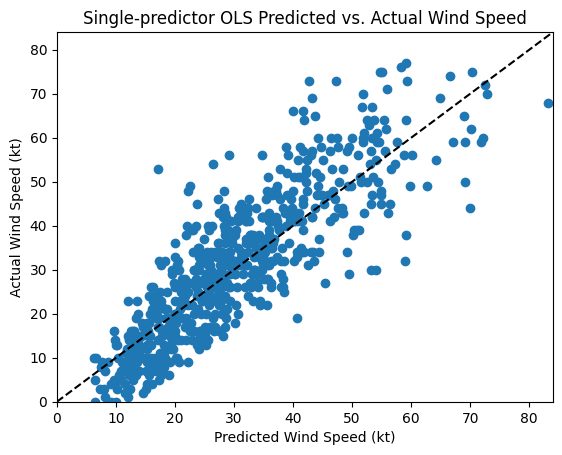

In [222]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

#Plot model predictions vs actual for test set
one_pred_OLS = LinearRegression().fit(features.iloc[train_indices]['ws8001'].values.reshape(-1, 1), labels.iloc[train_indices]['sknt'].values.reshape(-1, 1))
one_pred_OLS_predictions = one_pred_OLS.predict(features.iloc[validate_indices]['ws8001'].values.reshape(-1, 1))

plt.scatter(one_pred_OLS_predictions, labels.iloc[validate_indices]['sknt'].values.reshape(-1, 1))
plt.plot([0, 85], [0, 85], '--k')
plt.ylim([0, 84])
plt.xlim([0, 84])


plt.xlabel('Predicted Wind Speed (kt)')
plt.ylabel('Actual Wind Speed (kt)')
plt.title('Single-predictor OLS Predicted vs. Actual Wind Speed')

All-Predictors Linear Model for Non-Standardized Data

In [223]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

#Run OLS for all features, print cross validation mean and stdev (5 fold)
multi_pred_unscaled_OLS = LinearRegression().fit(features.iloc[train_and_validate_indices].values, labels.iloc[train_and_validate_indices]['sknt'].values.reshape(-1, 1))
multi_pred_unscaled_OLS_cv = cross_val_score(multi_pred_unscaled_OLS, features.iloc[train_and_validate_indices].values, labels.iloc[train_and_validate_indices]['sknt'].values.reshape(-1, 1))
multi_pred_unscaled_OLS_trainonly = LinearRegression().fit(features.iloc[train_indices].values, labels.iloc[train_indices]['sknt'].values.reshape(-1, 1))
multi_pred_unscaled_OLS_validscore = multi_pred_unscaled_OLS_trainonly.score(features.iloc[validate_indices].values, labels.iloc[validate_indices]['sknt'].values.reshape(-1, 1))


print(("Cross-validation mean R squared: " + str(multi_pred_unscaled_OLS_cv.mean())))
print(("Cross-validation stdev R squared: " + str(multi_pred_unscaled_OLS_cv.std())))
print(("Validation set R squared is: " + str(multi_pred_unscaled_OLS_validscore)))

Cross-validation mean R squared: 0.8400890649274327
Cross-validation stdev R squared: 0.0077167790059836415
Validation set R squared is: 0.8405126713777658


Text(0.5, 1.0, 'All-predictor OLS Predicted vs. Actual Wind Speed \n Non-Standardized Features')

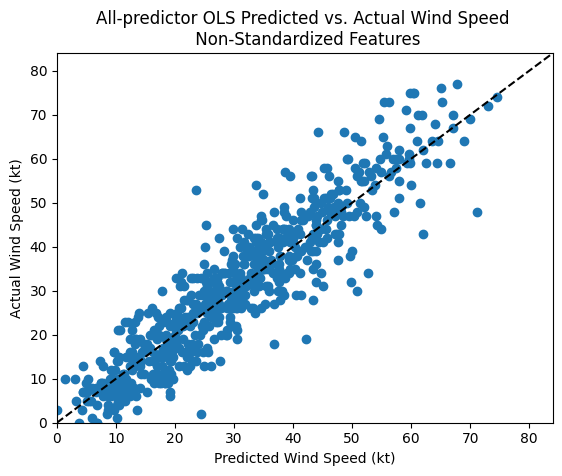

In [224]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

multi_pred_unscaled_OLS = LinearRegression().fit(features.iloc[train_indices].values, labels.iloc[train_indices]['sknt'].values.reshape(-1, 1))
multi_pred_unscaled_OLS_predictions = multi_pred_unscaled_OLS.predict(features.iloc[validate_indices].values)

plt.scatter(multi_pred_unscaled_OLS_predictions, labels.iloc[validate_indices]['sknt'].values.reshape(-1, 1))
plt.plot([0, 85], [0, 85], '--k')
plt.ylim([0, 84])
plt.xlim([0, 84])


plt.xlabel('Predicted Wind Speed (kt)')
plt.ylabel('Actual Wind Speed (kt)')
plt.title('All-predictor OLS Predicted vs. Actual Wind Speed \n Non-Standardized Features')

All-Predictors Linear Model for Standardized Data

In [225]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

multi_pred_OLS_standardized = LinearRegression().fit(all_features_array_scaled[train_and_validate_indices, :], labels.iloc[train_and_validate_indices]['sknt'].values.reshape(-1, 1))
multi_pred_OLS_standardized_cv = cross_val_score(multi_pred_OLS_standardized, all_features_array_scaled[train_and_validate_indices, :], labels.iloc[train_and_validate_indices]['sknt'].values.reshape(-1, 1))
multi_pred_OLS_standardized_trainonly = LinearRegression().fit(all_features_array_scaled[train_indices, :], labels.iloc[train_indices]['sknt'].values.reshape(-1, 1))
multi_pred_OLS_standardized_validscore = multi_pred_OLS_standardized_trainonly.score(all_features_array_scaled[validate_indices, :], labels.iloc[validate_indices]['sknt'].values.reshape(-1, 1))

print(("Cross-validation mean R squared: " + str(multi_pred_OLS_standardized_cv.mean())))
print(("Cross-validation stdev R squared: " + str(multi_pred_OLS_standardized_cv.std())))
print(("Validation set R squared is: " + str(multi_pred_OLS_standardized_validscore)))

Cross-validation mean R squared: 0.8401604631964655
Cross-validation stdev R squared: 0.00769088199291585
Validation set R squared is: 0.8407392741034052


In [230]:
a = np.zeros(len(all_features_array_scaled[test_indices, :][0]))
a[5] = 1
a

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [231]:
multi_pred_OLS_standardized.predict(all_features_array_scaled[test_indices[0], :].reshape(1, -1))

array([[14.92385881]])

In [232]:
multi_pred_OLS_standardized.predict((all_features_array_scaled[test_indices[0], :] + a).reshape(1, -1))

array([[-4.95229092e+12]])

Text(0.5, 1.0, 'All-predictor OLS Predicted vs. Actual Wind Speed \n Standardized Features')

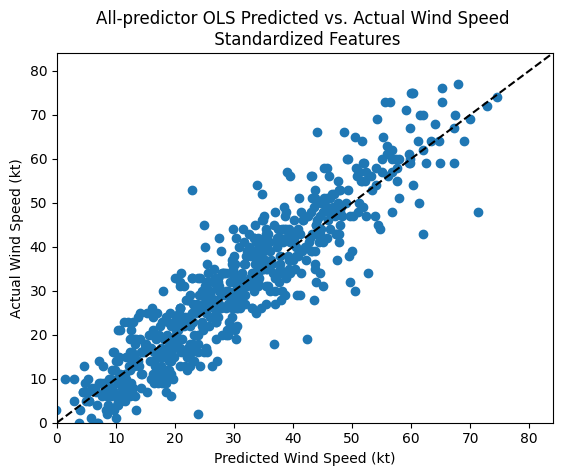

In [229]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

multi_pred_OLS_standardized = LinearRegression().fit(all_features_array_scaled[train_indices], labels.iloc[train_indices]['sknt'].values.reshape(-1, 1))
multi_pred_OLS_standardized_predictions = multi_pred_OLS_standardized.predict(all_features_array_scaled[validate_indices])

plt.scatter(multi_pred_OLS_standardized_predictions, labels.iloc[validate_indices]['sknt'].values.reshape(-1, 1))
plt.plot([0, 85], [0, 85], '--k')
plt.ylim([0, 84])
plt.xlim([0, 84])


plt.xlabel('Predicted Wind Speed (kt)')
plt.ylabel('Actual Wind Speed (kt)')
plt.title('All-predictor OLS Predicted vs. Actual Wind Speed \n Standardized Features')

Text(0.5, 1.0, 'All-Feature OLS with Standardized Data: \n Coefficient Magnitudes')

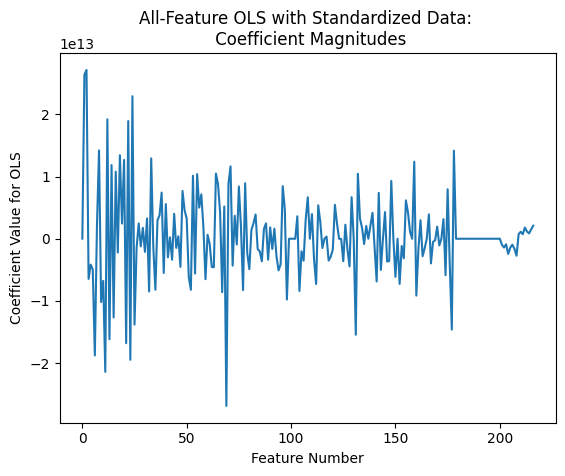

In [214]:
plt.plot(multi_pred_OLS_standardized.coef_[0])
plt.xlabel('Feature Number')
plt.ylabel('Coefficient Value for OLS')
plt.title('All-Feature OLS with Standardized Data: \n Coefficient Magnitudes')

In [188]:
#Do bootstrap to estimate prediction variance
bootstrap_pred_scores = []
bootstrap_w = []
for iter in range(50):
  bootstrap_indices = []
  for i in range(int(round(len(train_indices) / 2))):
    bootstrap_indices.append(train_indices[np.random.randint(0, len(train_indices))])
  bootstrap_indices = np.array(bootstrap_indices)
  multi_pred_OLS_standardized = LinearRegression().fit(all_features_array_scaled[bootstrap_indices, :], labels.iloc[bootstrap_indices]['sknt'].values.reshape(-1, 1))
  score = multi_pred_OLS_standardized.score(all_features_array_scaled[validate_indices, :], labels.iloc[validate_indices]['sknt'].values.reshape(-1, 1))
  w = multi_pred_OLS_standardized.coef_[0]
  bootstrap_pred_scores.append(score)
  bootstrap_w.append(w)
  
print('Mean of bootstrapped R squared is: ' + str(np.array(bootstrap_pred_scores).mean()))
print('StDev of bootstrapped R squared is: ' + str(np.array(bootstrap_pred_scores).std()))

Mean of bootstrapped R squared is: 0.8162492611617419
StDev of bootstrapped R squared is: 0.006494235900798501


In [189]:
np.array(bootstrap_w).std(axis = 0)

array([6.08634503e+09, 1.82361308e+13, 1.72240313e+13, 7.14122022e+12,
       1.49414749e+13, 1.39140996e+13, 2.67181211e+13, 1.17672022e+13,
       1.91902935e+13, 1.50111108e+13, 1.44779948e+13, 2.62810034e+13,
       2.79106560e+13, 1.02427896e+13, 8.89276617e+12, 9.61337659e+12,
       6.50871466e+12, 9.76637591e+12, 8.29208142e+12, 1.39611847e+13,
       1.14256423e+13, 9.68004944e+12, 1.77247693e+13, 1.07582093e+13,
       1.57205094e+13, 1.35916940e+13, 6.02464599e+12, 7.53185343e+12,
       1.17415457e+13, 9.07367678e+12, 1.04054481e+13, 5.65746555e+12,
       1.05764230e+13, 9.65556869e+12, 5.08882224e+12, 7.05787971e+12,
       4.59562204e+12, 8.22966584e+12, 8.16318590e+12, 8.96274675e+12,
       1.08442675e+13, 6.66739245e+12, 8.38384507e+12, 8.27637854e+12,
       6.34335188e+12, 8.18511978e+12, 9.86267689e+12, 1.54570593e+13,
       1.54923109e+13, 7.95377553e+12, 7.02297275e+12, 1.06078584e+13,
       8.97980540e+12, 5.43340602e+12, 5.36276452e+12, 5.94520990e+12,
      

All-Predictors Ridge Regression Linear Model for Standardized Data, L2 Regularization

Cross-validation mean R squared: 0.840483166365971
Cross-validation stdev R squared: 0.007094113125909896
Validation set R squared is: 0.8391315307098156


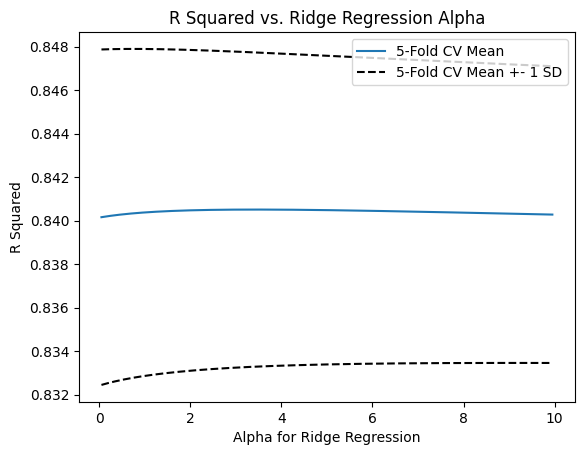

In [258]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

cv_means = []
cv_stds = []
for ridge_coeff in np.arange(0.05, 10, 0.05):
  multi_pred_ridge_standardized = Ridge(ridge_coeff).fit(all_features_array_scaled[train_and_validate_indices, :], labels.iloc[train_and_validate_indices]['sknt'].values.reshape(-1, 1))
  multi_pred_ridge_standardized_cv = cross_val_score(multi_pred_ridge_standardized, all_features_array_scaled[train_and_validate_indices, :], labels.iloc[train_and_validate_indices]['sknt'].values.reshape(-1, 1))
  cv_means.append(multi_pred_ridge_standardized_cv.mean())
  cv_stds.append(multi_pred_ridge_standardized_cv.std())

cv_means = np.array(cv_means)
cv_stds = np.array(cv_stds)

plt.plot(np.arange(0.05, 10, 0.05), cv_means, label = '5-Fold CV Mean')
plt.plot(np.arange(0.05, 10, 0.05), cv_means + cv_stds, '--k', label = "5-Fold CV Mean +- 1 SD")
plt.plot(np.arange(0.05, 10, 0.05), cv_means - cv_stds, '--k')
plt.xlabel('Alpha for Ridge Regression')
plt.ylabel('R Squared')
plt.title('R Squared vs. Ridge Regression Alpha')
plt.legend()

multi_pred_ridge_standardized = Ridge(5).fit(all_features_array_scaled[train_and_validate_indices, :], labels.iloc[train_and_validate_indices]['sknt'].values.reshape(-1, 1))
multi_pred_ridge_standardized_cv = cross_val_score(multi_pred_ridge_standardized, all_features_array_scaled[train_and_validate_indices, :], labels.iloc[train_and_validate_indices]['sknt'].values.reshape(-1, 1))
multi_pred_ridge_standardized_trainonly = Ridge(5).fit(all_features_array_scaled[train_indices, :], labels.iloc[train_indices]['sknt'].values.reshape(-1, 1))
multi_pred_ridge_standardized_validscore = multi_pred_ridge_standardized_trainonly.score(all_features_array_scaled[validate_indices, :], labels.iloc[validate_indices]['sknt'].values.reshape(-1, 1))

print(("Cross-validation mean R squared: " + str(multi_pred_ridge_standardized_cv.mean())))
print(("Cross-validation stdev R squared: " + str(multi_pred_ridge_standardized_cv.std())))
print(("Validation set R squared is: " + str(multi_pred_ridge_standardized_validscore)))

In [252]:
#Do bootstrap to estimate prediction variance
bootstrap_pred_scores = []
bootstrap_w = []
for iter in range(50):
  bootstrap_indices = []
  for i in range(int(round(len(train_indices) / 2))):
    bootstrap_indices.append(train_indices[np.random.randint(0, len(train_indices))])
  bootstrap_indices = np.array(bootstrap_indices)
  multi_pred_ridge_standardized = Ridge(5).fit(all_features_array_scaled[bootstrap_indices, :], labels.iloc[bootstrap_indices]['sknt'].values.reshape(-1, 1))
  score = multi_pred_ridge_standardized.score(all_features_array_scaled[validate_indices, :], labels.iloc[validate_indices]['sknt'].values.reshape(-1, 1))
  bootstrap_pred_scores.append(score)
  bootstrap_w.append(multi_pred_ridge_standardized.coef_[0])
  
print('Mean of bootstrapped R squared is: ' + str(np.array(bootstrap_pred_scores).mean()))
print('StDev of bootstrapped R squared is: ' + str(np.array(bootstrap_pred_scores).std()))

Mean of bootstrapped R squared is: 0.8180852765542704
StDev of bootstrapped R squared is: 0.007272981907228511


In [253]:
np.array(bootstrap_w).std(axis = 0)

array([0.35111551, 0.20525981, 0.25908185, 0.15801182, 0.2665225 ,
       0.46521058, 0.2434597 , 0.43479919, 0.24645936, 0.30308934,
       0.19978266, 0.20025177, 0.13285908, 0.21405768, 0.3559027 ,
       0.18979   , 0.30031191, 0.17557291, 0.35377772, 0.26448341,
       0.24552535, 0.23497549, 0.28508218, 0.42856313, 0.30546227,
       0.45957182, 0.31618701, 0.25788579, 0.16379934, 0.15311067,
       0.14774332, 0.14725866, 0.24456428, 0.14843327, 0.20144707,
       0.15047269, 0.37794421, 0.27636286, 0.22153624, 0.2030617 ,
       0.23300564, 0.47500382, 0.2368919 , 0.39627874, 0.22759532,
       0.26440915, 0.15512052, 0.17531532, 0.12872791, 0.23003468,
       0.3022559 , 0.19453586, 0.25651447, 0.18382007, 0.18352931,
       0.15938466, 0.13167359, 0.12186341, 0.1791855 , 0.22811475,
       0.12982555, 0.19130262, 0.16198308, 0.19412052, 0.25096889,
       0.18495029, 0.13866018, 0.27335883, 0.25973145, 0.15182716,
       0.22854896, 0.16594331, 0.25911451, 0.16922285, 0.18141

Text(0.5, 1.0, 'All-predictor Ridge Regression Predicted vs. Actual Wind Speed \n Standardized Features')

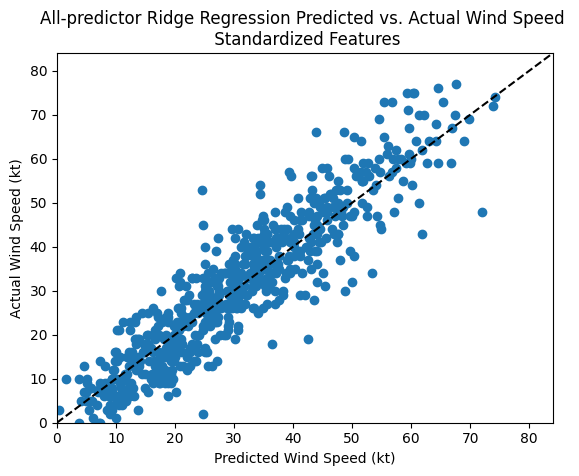

In [254]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

multi_pred_ridge_standardized = Ridge(5).fit(all_features_array_scaled[train_indices], labels.iloc[train_indices]['sknt'].values.reshape(-1, 1))
multi_pred_ridge_standardized_predictions = multi_pred_ridge_standardized.predict(all_features_array_scaled[validate_indices])

plt.scatter(multi_pred_ridge_standardized_predictions, labels.iloc[validate_indices]['sknt'].values.reshape(-1, 1))
plt.plot([0, 85], [0, 85], '--k')
plt.ylim([0, 84])
plt.xlim([0, 84])


plt.xlabel('Predicted Wind Speed (kt)')
plt.ylabel('Actual Wind Speed (kt)')
plt.title('All-predictor Ridge Regression Predicted vs. Actual Wind Speed \n Standardized Features')

Text(0.5, 1.0, 'All-Feature Ridge Regression (alpha = 5) with Standardized Data: \n Coefficient Magnitudes')

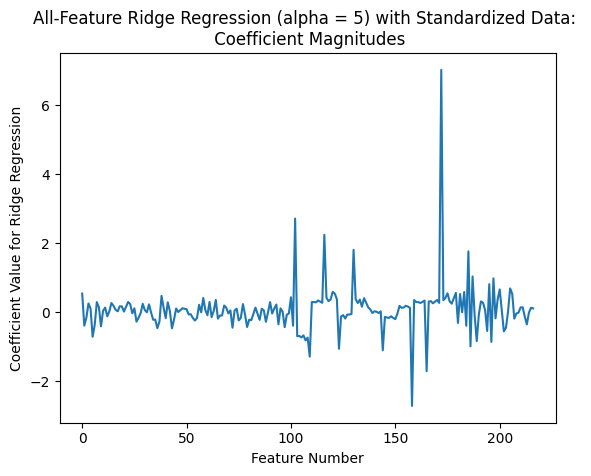

In [256]:
plt.plot(multi_pred_ridge_standardized.coef_[0])
plt.xlabel('Feature Number')
plt.ylabel('Coefficient Value for Ridge Regression')
plt.title('All-Feature Ridge Regression (alpha = 5) with Standardized Data: \n Coefficient Magnitudes')

All-Predictors Lasso Regression Linear Model for Standardized Data, L1 Regularization

0.05
0.1
0.15000000000000002
0.2
0.25
0.3
0.35000000000000003
0.4
0.45
0.5
0.55
0.6000000000000001
0.6500000000000001
0.7000000000000001
0.7500000000000001
0.8
0.8500000000000001
0.9000000000000001
0.9500000000000001
1.0
1.05
1.1
1.1500000000000001
1.2000000000000002
1.2500000000000002
1.3
1.35
1.4000000000000001
1.4500000000000002
1.5000000000000002
1.55
1.6
1.6500000000000001
1.7000000000000002
1.7500000000000002
1.8
1.85
1.9000000000000001
1.9500000000000002
2.0
2.05
2.1
2.15
2.1999999999999997
2.25
2.3
2.35
2.4
2.45
2.5
2.55
2.6
2.65
2.7
2.75
2.8
2.85
2.9
2.95
3.0
3.05
3.1
3.15
3.2
3.25
3.3
3.35
3.4
3.45
3.5
3.55
3.6
3.65
3.7
3.75
3.8
3.85
3.9
3.95
4.0
4.05
4.1
4.15
4.2
4.25
4.3
4.35
4.4
4.45
4.5
4.55
4.6
4.65
4.7
4.75
4.8
4.8500000000000005
4.9
4.95
Cross-validation mean R squared: 0.8286663666561864
Cross-validation stdev R squared: 0.008295282584966094
Validation set R squared is: 0.8234178870687626


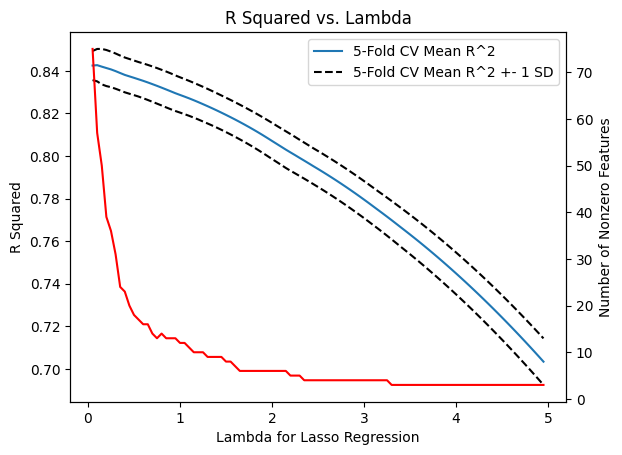

In [260]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

cv_means = []
cv_stds = []
nonzeros = []
for lasso_coeff in np.arange(0.05, 5, 0.05):
  print(lasso_coeff)
  multi_pred_lasso_standardized = Lasso(lasso_coeff).fit(all_features_array_scaled[train_and_validate_indices, :], labels.iloc[train_and_validate_indices]['sknt'].values.reshape(-1, 1))
  multi_pred_lasso_standardized_cv = cross_val_score(multi_pred_lasso_standardized, all_features_array_scaled[train_and_validate_indices, :], labels.iloc[train_and_validate_indices]['sknt'].values.reshape(-1, 1))
  cv_means.append(multi_pred_lasso_standardized_cv.mean())
  cv_stds.append(multi_pred_lasso_standardized_cv.std())
  nonzeros.append((abs(multi_pred_lasso_standardized.coef_) > 0).sum())

cv_means = np.array(cv_means)
cv_stds = np.array(cv_stds)

fig, ax = plt.subplots(1, 1)
ax.plot(np.arange(0.05, 5, 0.05), cv_means, label = '5-Fold CV Mean R^2')
ax.plot(np.arange(0.05, 5, 0.05), cv_means + cv_stds, '--k', label = "5-Fold CV Mean R^2 +- 1 SD")
ax.plot(np.arange(0.05, 5, 0.05), cv_means - cv_stds, '--k')
ax2 = ax.twinx()
ax2.plot(np.arange(0.05, 5, 0.05), nonzeros, 'r', label = 'Nonzero Features')
ax2.set_ylabel("Number of Nonzero Features")

ax.set_xlabel('Lambda for Lasso Regression')
ax.set_ylabel('R Squared')
plt.title('R Squared vs. Lambda')
#plt.legend(loc = 'center right')
ax.legend()

multi_pred_lasso_standardized = Lasso(1).fit(all_features_array_scaled[train_and_validate_indices, :], labels.iloc[train_and_validate_indices]['sknt'].values.reshape(-1, 1))
multi_pred_lasso_standardized_cv = cross_val_score(multi_pred_lasso_standardized, all_features_array_scaled[train_and_validate_indices, :], labels.iloc[train_and_validate_indices]['sknt'].values.reshape(-1, 1))
multi_pred_lasso_standardized_trainonly = Lasso(1).fit(all_features_array_scaled[train_indices, :], labels.iloc[train_indices]['sknt'].values.reshape(-1, 1))
multi_pred_lasso_standardized_validscore = multi_pred_lasso_standardized_trainonly.score(all_features_array_scaled[validate_indices, :], labels.iloc[validate_indices]['sknt'].values.reshape(-1, 1))

print(("Cross-validation mean R squared: " + str(multi_pred_lasso_standardized_cv.mean())))
print(("Cross-validation stdev R squared: " + str(multi_pred_lasso_standardized_cv.std())))
print(("Validation set R squared is: " + str(multi_pred_lasso_standardized_validscore)))

Text(0.5, 1.0, 'All-Feature Lasso Regression (lambda = 1) with Standardized Data: \n Coefficient Magnitudes')

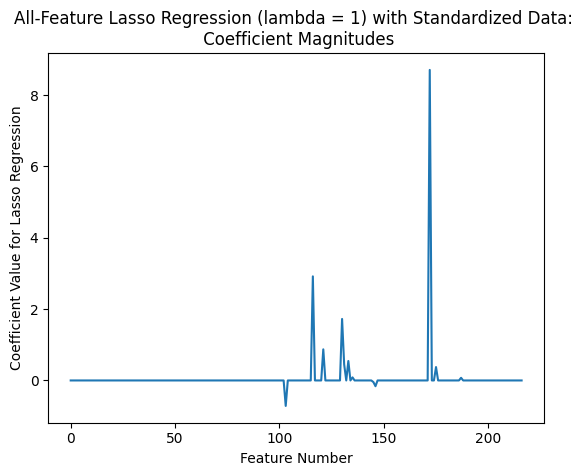

In [261]:
plt.plot(multi_pred_lasso_standardized.coef_)
plt.xlabel('Feature Number')
plt.ylabel('Coefficient Value for Lasso Regression')
plt.title('All-Feature Lasso Regression (lambda = 1) with Standardized Data: \n Coefficient Magnitudes')

In [274]:
multi_pred_lasso_standardized.coef_[130]

1.7238549917941641

In [275]:
features.columns.values[130]

'wssfc1'